In [1]:
### ARIMA Modeling

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [3]:
### Load data: Tororto Ferry Tickets 2022 onwards
from pathlib import Path

base_dir = Path().cwd().parent
data_path = base_dir / "data" / "processed" / "daily_tickets_2022_25.parquet"

print(f"Loading data from: {data_path}")

data = pd.read_parquet(data_path) 

Loading data from: c:\Users\elias\Documents\MLOps\mlflow_prophet_lightgbm\data\processed\daily_tickets_2022_25.parquet


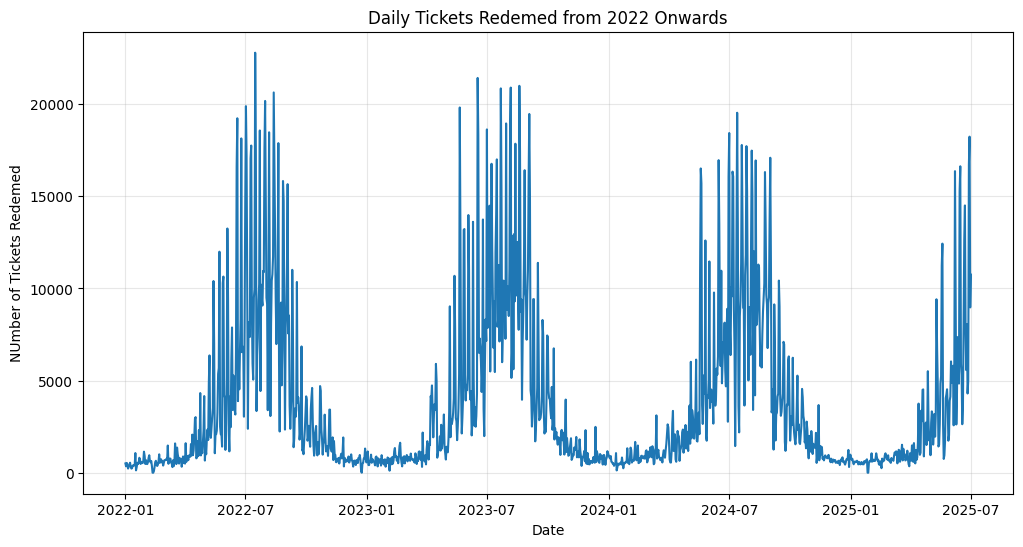

In [4]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=data, x="Timestamp", y="Redemption Count", ax=ax)
ax.set_title("Daily Tickets Redemed from 2022 Onwards")
ax.set_xlabel("Date")
ax.set_ylabel("NUmber of Tickets Redemed")
plt.grid(alpha=0.3)
plt.show()



In [ ]:
data["log_transformed_redem"] = np.log1p(data["Redemption Count"])
data["log_transformed_sales"] = np.log1p(data["Sales Count"])
data["diff_log_redem"] = data["log_transformed_redem"].diff()
data = data.dropna().reset_index(drop=True)

display(data.head())

,Timestamp,Redemption Count,Sales Count,log_transformed_redem,log_transformed_sales,diff_log_redem
0,2022-01-02,345,322,5.846439,5.777652,-0.376137
1,2022-01-03,532,503,6.278521,6.222576,0.432083
2,2022-01-04,475,412,6.165418,6.023448,-0.113104
3,2022-01-05,225,201,5.420535,5.308268,-0.744883
4,2022-01-06,358,324,5.883322,5.783825,0.462787


In [6]:
import plotly.express  as px
fig = px.scatter(data, x="Timestamp", y=["log_transformed_redem", "log_transformed_sales"], title="Log Transformed Redemption and Sales Counts Over Time")
fig.show()

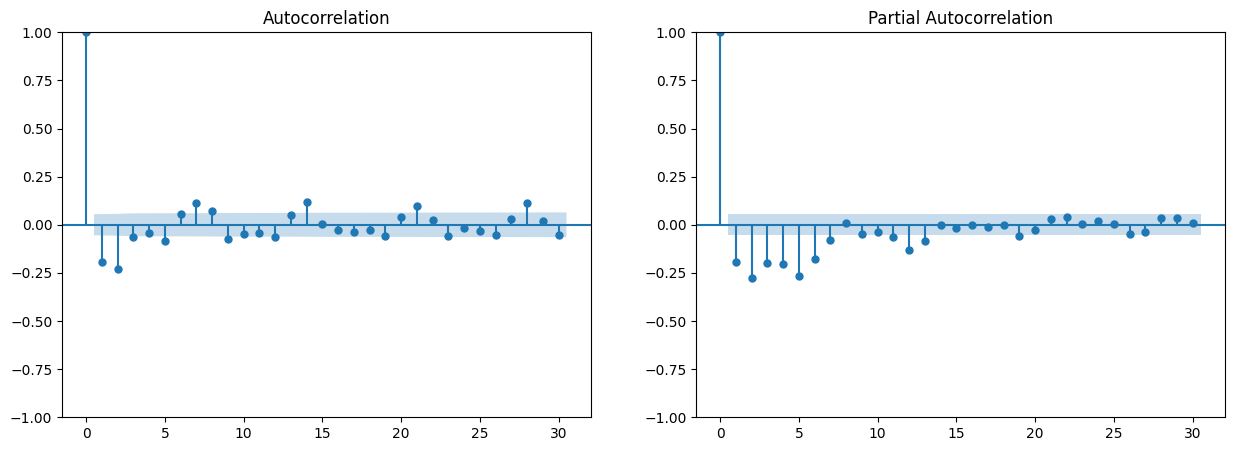

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(data["diff_log_redem"], lags=30, ax=ax[0])
plot_pacf(data["diff_log_redem"], lags=30, ax=ax[1])
plt.show()
# Define ARIMA model parameters

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [9]:
data.head()

,Timestamp,Redemption Count,Sales Count,log_transformed_redem,log_transformed_sales,diff_log_redem
0,2022-01-02,345,322,5.846439,5.777652,-0.376137
1,2022-01-03,532,503,6.278521,6.222576,0.432083
2,2022-01-04,475,412,6.165418,6.023448,-0.113104
3,2022-01-05,225,201,5.420535,5.308268,-0.744883
4,2022-01-06,358,324,5.883322,5.783825,0.462787


In [10]:
df = data.copy()  # or your original dataframe
df = df[['Timestamp', 'log_transformed_redem', 'log_transformed_sales']].dropna()
df = df.set_index('Timestamp')
y = df['log_transformed_redem']
y_log_sales = df["log_transformed_sales"]



In [11]:
def evaluate_sarima_with_tscv(y, order=(1,0,0), seasonal_order=(0,0,0,0), n_splits=5):
    """
    Perform TimeSeriesSplit CV for SARIMA model.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=7)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(y)):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        # exog_train, exog_test = y_sales.iloc[train_idx], y_sales.iloc[test_idx]

        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        result = model.fit(disp=False)

        preds = result.forecast(steps=len(y_test)) #, exog=exog_test)
        forecasted_object = result.get_forecast(steps=len(y_test)) #, exog=exog_test)
        mean_predictions = forecasted_object.predicted_mean
        confidenceinterval = forecasted_object.conf_int()
        
       
        fig, ax = plt.subplots(2,1, figsize=(10,4))
        ax[0].plot(y_train.index[-50:], y_train[-50:], label='Train Set')
        ax[0].plot(y_test.index, y_test, label='Observed', color='green', linestyle='dashed') 
        ax[0].plot(preds.index, preds, label='Forecast', color='orange')
        # ax.plot(mean_predictions.index, mean_predictions, label='Mean Prediction', color='red')
        ax[0].fill_between(confidenceinterval.index, confidenceinterval.iloc[:,0], 
                        confidenceinterval.iloc[:,1], color='pink', alpha=0.3, label='Confidence Interval')
        
        ax[0].set_title(f'SARIMA Forecast (log transforemed) - Fold {fold+1}')
        ax[0].legend()

        ax[1].plot(y_train.index[-50:], np.expm1(y_train[-50:]), label='Train Set')
        ax[1].plot(y_test.index, np.expm1(y_test), label='Observed', color='green', linestyle='dashed') 
        ax[1].plot(preds.index, np.expm1(preds), label='Forecast', color='orange')
        # ax.plot(mean_predictions.index, mean_predictions, label='Mean Prediction', color='red')
        # ax[1].fill_between(confidenceinterval.index, confidenceinterval.iloc[:,0], 
        #                 confidenceinterval.iloc[:,1], color='pink', alpha=0.3, label='Confidence Interval')
        
        ax[1].set_title(f'SARIMA Forecast (ORIGINAL SERIES) - Fold {fold+1}')
        ax[1].legend()
        plt.tight_layout()
        plt.show()      
        
        
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        fold_results.append({'fold': fold+1, 'MAE': mae, 'RMSE': rmse})

        print(f"Fold {fold+1}: MAE={mae:.4f}, RMSE={rmse:.4f}")

    results_df = pd.DataFrame(fold_results)
    print("\nAverage metrics:")
    print(results_df.mean(numeric_only=True))

    return results_df


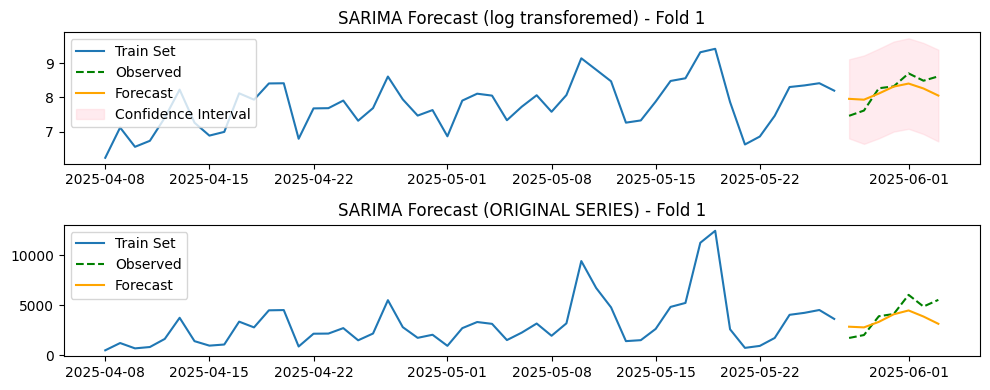

Fold 1: MAE=0.2957, RMSE=0.3451


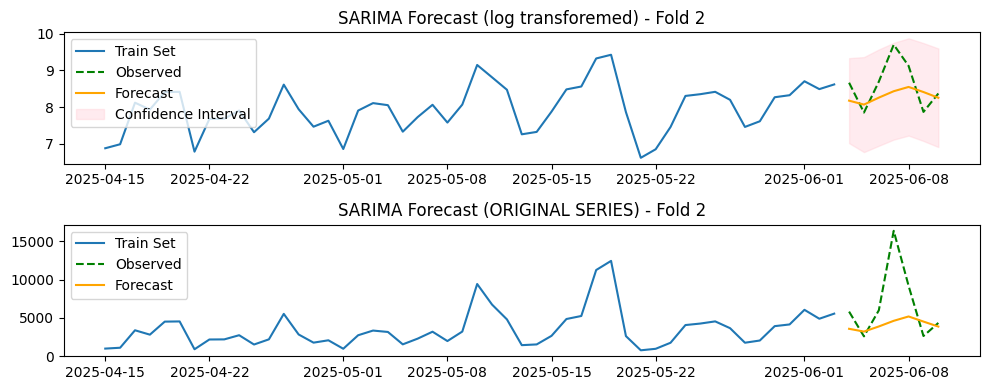

Fold 2: MAE=0.5204, RMSE=0.6236


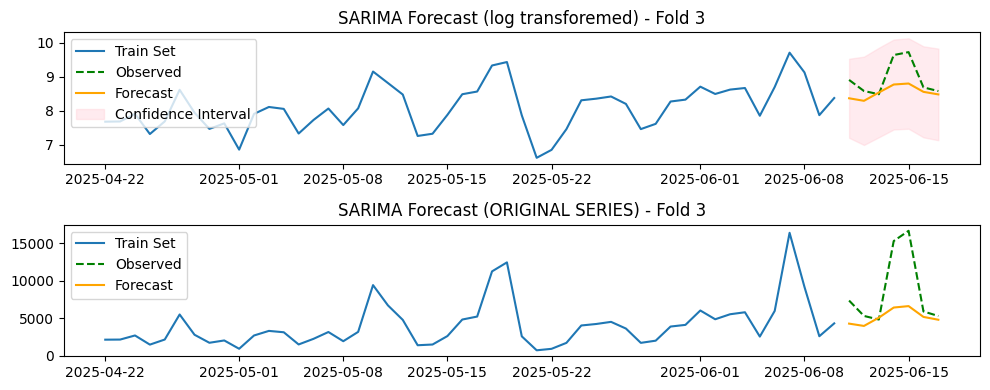

Fold 3: MAE=0.4129, RMSE=0.5341


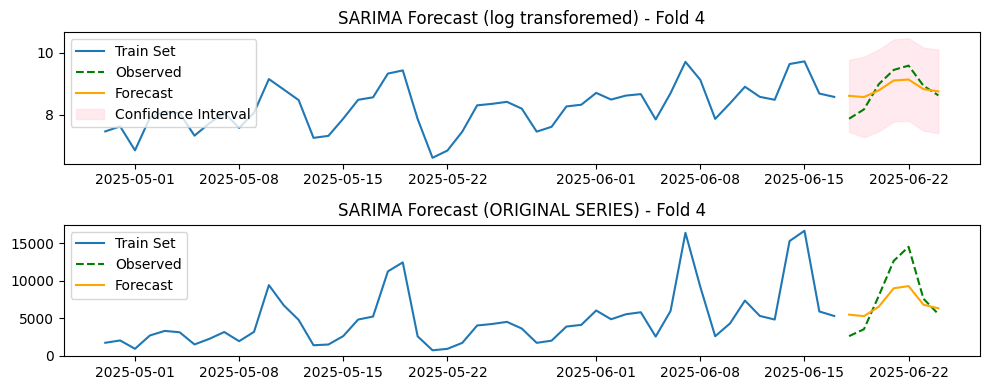

Fold 4: MAE=0.3367, RMSE=0.3931


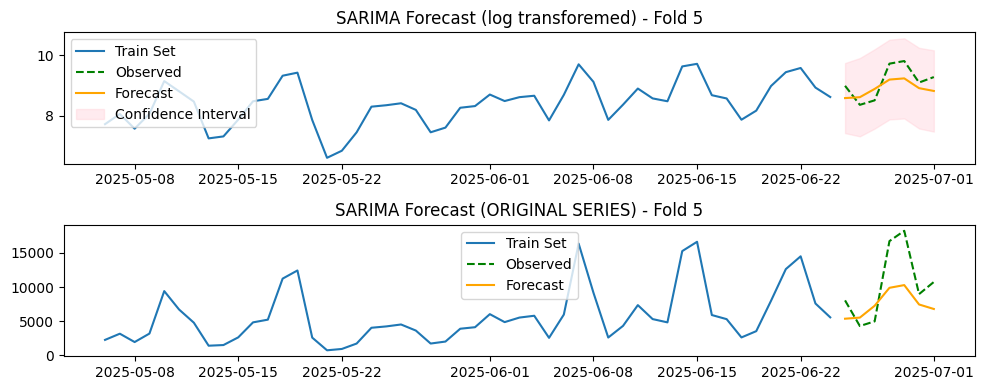

Fold 5: MAE=0.3964, RMSE=0.4170

Average metrics:
fold    3.000000
MAE     0.392415
RMSE    0.462572
dtype: float64


In [13]:
results = evaluate_sarima_with_tscv(
    y,
    order=(2,1,2),              # ARIMA(p,d,q)
    seasonal_order=(1,0,1,7),   # SARIMA(P,D,Q,s)
    n_splits=5
)


In [ ]:
display(results)

In [14]:
final_model = SARIMAX(
    y,
    order=(2,1,2),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_res = final_model.fit(disp=False)

forecast_steps = 7
future_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast = final_res.forecast(steps=forecast_steps)
forecasted_object = final_res.get_forecast(steps=forecast_steps)
mean_forecast = forecasted_object.predicted_mean
confint = forecasted_object.conf_int()

forecast = pd.Series(forecast, index=future_index)

                                      SARIMAX Results                                      
Dep. Variable:               log_transformed_redem   No. Observations:                 1277
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1129.525
Date:                             Tue, 04 Nov 2025   AIC                           2273.050
Time:                                     11:30:03   BIC                           2309.056
Sample:                                 01-02-2022   HQIC                          2286.578
                                      - 07-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3908      0.250      1.561      0.119      -0.100       0.882
ar.L2         -0.1108      

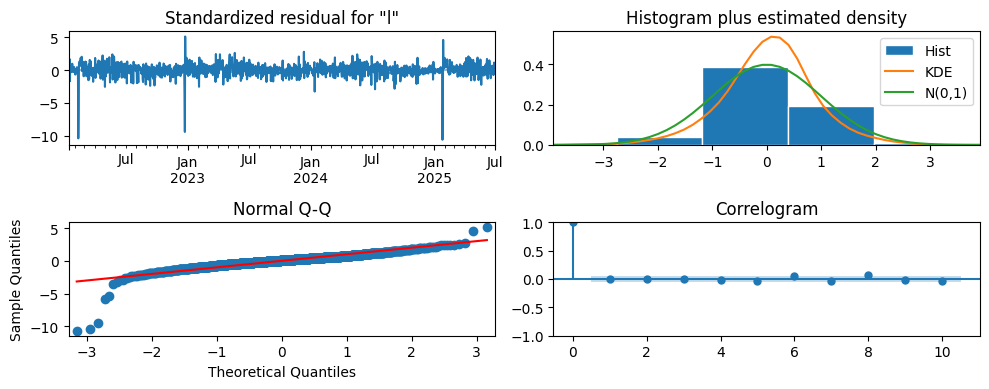

In [15]:
# Print model summary
print(final_res.summary())

# Plot residual diagnostics
final_res.plot_diagnostics(figsize=(10, 4))
plt.tight_layout()
plt.show()

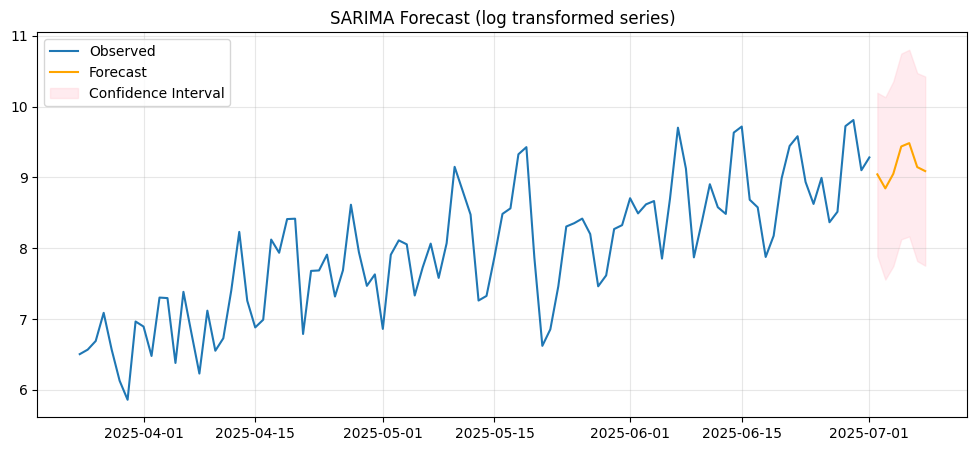

In [16]:
plt.figure(figsize=(12,5))
plt.plot(y[-100:], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='orange')
plt.fill_between(confint.index, confint.iloc[:,0], confint.iloc[:,1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast (log transformed series)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# plt.savefig(base_dir / "output" / "plots" / "sarima_forecast.png")

In [ ]:
# import joblib
# model_path = cur_dir.parent / "models"
# model_path.mkdir(parents=True, exist_ok=True)
# joblib.dump(final_res, model_path / "sarima_model.pkl")# 



In [17]:
tracking_path = base_dir / "mlruns"
tracking_path = (base_dir / "mlruns").resolve()  # ensure absolute path
tracking_path.mkdir(exist_ok=True)

In [18]:
tracking_path_uri = tracking_path.as_uri()
tracking_path_uri


'file:///C:/Users/elias/Documents/MLOps/mlflow_prophet_lightgbm/mlruns'

In [22]:
import mlflow
from mlflow.models import infer_signature



mlflow.set_tracking_uri(tracking_path_uri)

mlflow.set_experiment("SARIMA_Toronto_Ferry_Tickets")

with mlflow.start_run(run_name="SARIMA_Modeling") as run:
    mlflow.log_param("order", (2,1,2))
    mlflow.log_param("seasonal_order", (1,0,1,7))
    avg_mae = results['MAE'].mean()
    avg_rmse = results['RMSE'].mean()
    mlflow.log_metric("avg_MAE", avg_mae)
    mlflow.log_metric("avg_RMSE", avg_rmse)
    mlflow.log_metric("AIC", final_res.aic)
    mlflow.log_metric("BIC", final_res.bic)
    mlflow.log_metric("HQIC", final_res.hqic)
    mlflow.log_text(final_res.summary().as_text(), "model_summary.txt")
    
    mlflow.log_artifact(base_dir / "output" /"plots"/ "daily_redemption_count_2022_onwards.png", artifact_path="plots")
    
    mlflow.log_artifact(base_dir / "output" / "plots" / "sarima_forecast.png", artifact_path="plots")
    
    input_data_sample = df[["log_transformed_redem"]].head(10)  # or df[['y']].head(10) if you prefer DataFrame

    # Generate output for signature
    forecast_steps = 3
    output_sample = final_res.forecast(steps=forecast_steps)
    
    # Infer signature
    signature = infer_signature(input_data_sample, output_sample)

# Log model with input_example and signature
    mlflow.statsmodels.log_model(
    final_res,
    artifact_path="sarima_model",
    input_example=input_data_sample,
    signature=signature
    )

    print(f"Logged SARIMA model with run_id: {run.info.run_id}")
    

2025/11/04 11:35:02 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
MlflowException('prediction dataframes for a TimeSeriesModel must have exactly one row and include columns called start and end')Traceback (most recent call last):


  File "c:\Users\elias\Documents\MLOps\mlflow_prophet_lightgbm\.venv\Lib\site-packages\mlflow\utils\_capture_modules.py", line 165, in load_model_and_predict
    model.predict(input_example, params=params)


  File "c:\Users\elias\Documents\MLOps\mlflow_prophet_lightgbm\.venv\Lib\site-packages\mlflow\statsmodels\__init__.py", line 352, in predict
    raise MlflowException(


mlflow.exceptions.MlflowException: prediction dataframes for a TimeSeriesModel must have exactly one row and include columns called start and end
2025/11/04 11:35:03 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "log_transformed_r

Logged SARIMA model with run_id: 742bfa17610144a89b5e7079ff89d1c3
